In this project we go over step by step process of building a simle unidirectional LSTM networks for priority classification based on messages/tweets/comments and consumer reviews that will help buisnesses effectively meet the need of consumers by analysing what they have to say.

Long short-term memory (LSTM) units (or blocks) are a building unit for layers of a recurrent neural network (RNN). An RNN composed of LSTM units is often called an LSTM network. A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell is responsible for "remembering" values over arbitrary time intervals; hence the word "memory" in LSTM. Each of the three gates can be thought of as a "conventional" artificial neuron, as in a multi-layer (or feedforward) neural network: that is, they compute an activation (using an activation function) of a weighted sum. Intuitively, they can be thought as regulators of the flow of values that goes through the connections of the LSTM; hence the denotation "gate". There are connections between these gates and the cell.

source:https://en.wikipedia.org/wiki/Long_short-term_memory

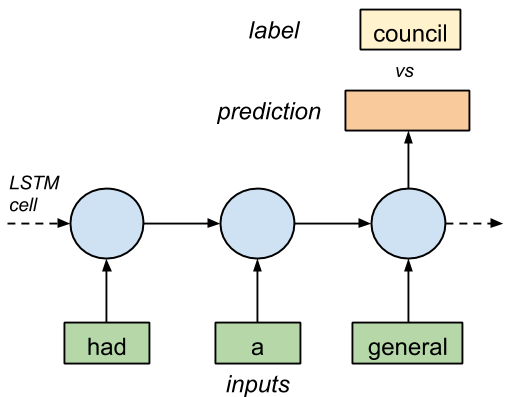

In [1]:
from IPython.display import Image
Image(filename='lstm.png')

In [1]:
import sys
import tensorflow as tf
from termcolor import colored
print(colored('Python Version: %s' % sys.version.split()[0], 'blue'))
print(colored('TensorFlow Ver: %s' % tf.__version__, 'magenta'))

Python Version: 3.6.2
TensorFlow Ver: 1.3.0


##
We use tensorflow as our machine learning library.
https://www.tensorflow.org/

In [4]:
n_epoch = 10

###
No of epoch could have been set as 1 since we were dealing with a very large dataset.
###

In [5]:
import pandas as pd
pd.set_option('display.max_colwidth', 1000)


###
We use pandas to read the dataset, convert them into a panda dataframe and do modifications to this dataframe.
https://pandas.pydata.org/
###

In [6]:
yelp = pd.read_csv('yelp.csv')
yelp.head(10)


/home/bahushruth/anaconda3/envs/py3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,score,Description,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,NaN,5,"dr. goldberg offers everything i look for in a general practitioner. he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first. really, what more do you need? i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a blank.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,2,"Unfortunately, the frustration of being Dr. Goldberg's patient is a repeat of the experience I've had with so many other doctors in NYC -- good doctor, terrible staff. It seems that his staff simply never answers the phone. It usually takes 2 hours of repeated calling to get an answer. Who has time for that or wants to deal with it? I have run into this problem with many other doctors and I just don't get it. You have office workers, you have patients with medical needs, why isn't anyone answering the phone? It's incomprehensible and not work the aggravation. It's with regret that I feel that I have to give Dr. Goldberg 2 stars.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,4,"Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very patient and understanding. He doesn't judge and asks all the right questions. Very thorough and wants to be kept in the loop on every aspect of your medical health and your life.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,4,Got a letter in the mail last week that said Dr. Goldberg is moving to Arizona to take a new position there in June. He will be missed very much. \n\nI think finding a new doctor in NYC that you actually like might almost be as awful as trying to find a date!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1,"I don't know what Dr. Goldberg was like before moving to Arizona, but let me tell you, STAY AWAY from this doctor and this office. I was going to Dr. Johnson before he left and Goldberg took over when Johnson left. He is not a caring doctor. He is only interested in the co-pay and having you come in for medication refills every month. He will not give refills and could less about patients's financial situations. Trying to get your 90 days mail away pharmacy prescriptions through this guy is a joke. And to make matters even worse, his office staff is incompetent. 90% of the time when you call the office, they'll put you through to a voice mail, that NO ONE ever answers or returns your call. Both my adult children and husband have decided to leave this practice after experiencing such frustration. The entire office has an attitude like they are doing you a favor. Give me a break! Stay away from this doc and the practice. You deserve better and they will not be there when you really ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,5,Top notch doctor in a top notch practice. Can't say I am surprised when I was referred to him by another doctor who I think is wonderful and because he went to one of the best medical schools in the country. \nIt is really easy to get an appointment. There is minimal wait to be seen and his bedside manner is great.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,5,"Dr. Eric Goldberg is a fantastic doctor who has correctly diagnosed every issue that my wife and I have had. Unlike many of my past doctors, Dr. Goldberg is very accessible and we have been able to schedule appointments with him and his staff very quickly. We are happy to ha

In [7]:
rank = ['1', '2', '3']
yelp['priority'] = yelp.score.isin(rank).map({True: 'High_priority', False: 'Low_priority'})

#
Simple logic used to determine the priority of a statement.
A person who would rate any given service 3 or below 3 has some valuable insights to give about the kind of service he recieved. This was understood by loooking at the dataset.

In [8]:
yelp.priority.value_counts()

High_priority    390000
Low_priority     260000
Name: priority, dtype: int64

#
Here we can see the no of high priority reviews and low priority reviews

In [11]:
X = yelp.Description
y = yelp.priority

#
We are trying to create an end to end network that tells us weather a given tweet in of low priority or high priority based on an input Description.

Can be expressed as 
Y = f(x)

Displaying 10 values of X

In [12]:
X.head(10)

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     dr. goldberg offers everything i look for in a general practitioner.  he's nice and easy to talk to without being patronizing; he's always on time in seeing his patients; he's affiliated with a top-notch hospital (nyu) which my parents have explained to me is very important in case something happens and you need surgery; and you can get referrals to see specialists without having to see him first.  really, what more do you need?  i'm sitting here trying to think of any complaints i have about him, but i'm really drawing a bl

#
Displaying 10 values of Y 

In [13]:
y.head(10)

0     Low_priority
1    High_priority
2     Low_priority
3     Low_priority
4    High_priority
5     Low_priority
6     Low_priority
7    High_priority
8    High_priority
9    High_priority
Name: priority, dtype: object

#
Now let us build a network that can accurately map the values of Y to X

In [14]:
import tflearn
from tflearn.data_utils import to_categorical, pad_sequences

#
We use tflearn library to build our network.
We also use tflearn to pad our data and convert the y labels to vectors(using to_categorical function).

http://tflearn.org/

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.004, random_state=42)

#
We use scikit learn to split our data into test and train data.
We chose the size of the test data to be 0.004 times the training data.
This is unconventional as the ratio of Training data to Test data is usually 7:3
This had to be done since our data set comprises of 650,000 reviews and converting 30% of this would leave us with testing data consisting of 195,000. If we did this while testing the network we will get an error since the Vram of our laptop isnt big enough to allocate memory to the tensor of size 195000(no of examples),150(max length of our sentences),120(batch size).

After a few modifications to the parmeter ie changing batch size,maxlength and finally no of testing examples we came up with this ratio of 0.004.

https://github.com/tensorflow/tensorflow/issues/136
This thread provides useful insights for this error 

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(ngram_range=(1,1), token_pattern=r'\b\w{1,}\b')

In [17]:
vect.fit(X_train)
vocab = vect.vocabulary_


#
We also use Scikit learn to Tokenize these words and then obtain word vectors

http://scikit-learn.org/stable/

In [18]:
def convert_X_to_X_word_ids(X):
    return X.apply( lambda x: [vocab[w] for w in [w.lower().strip() for w in x.split()] if w in vocab] )

#
We use this above function to convert words to word ids
Why do we do this?

In [19]:
X_train_word_ids = convert_X_to_X_word_ids(X_train)
X_test_word_ids  = convert_X_to_X_word_ids(X_test)

#
We need to convert these words into word ids since the pad_sequence function of tflearn requires an int value as 
arguments.

http://tflearn.org/data_utils/
For more information check this link.

#
Why do we need to perform padding?

Padding is necessary to ensure consistency in the inputs dimensionality.

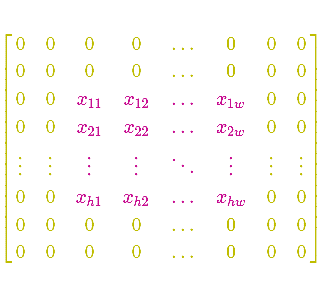

In [3]:
from IPython.display import Image
Image(filename='padding.png')

#
Above is an image of a padded matrix.

https://www.coursera.org/learn/convolutional-neural-networks/lecture/o7CWi/padding
This link provides good insights about padding.

In [20]:
X_train_padded_seqs = pad_sequences(X_train_word_ids, maxlen=150, value=0)
X_test_padded_seqs  = pad_sequences(X_test_word_ids , maxlen=150, value=0)

In [21]:
out = list(y_train.value_counts().index)
out

['High_priority', 'Low_priority']

In [22]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(out)

LabelEncoder()

#
LabelEncoder function is used to encode the labels as 0 and 1 corresponding to the labels High_priority and Low_priority.

http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

#
Now using the to_categorical function we convert the encoded values to vectors.
http://tflearn.org/data_utils/

In [24]:
y_train = to_categorical(y_train.map(lambda x: le.transform([x])[0]), nb_classes=len(out))
y_test  = to_categorical(y_test.map(lambda x:  le.transform([x])[0]), nb_classes=len(out))

In [25]:
vectorsize = X_train_padded_seqs.shape[1]
vocabsize = len(vocab)
labelcount = len(out)

Now we build our network

The optimzer we are using is the adam optimizer and loss is categorical_crossentropy.

https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/
https://rdipietro.github.io/friendly-intro-to-cross-entropy-loss/

In [26]:
net = tflearn.input_data([None, vectorsize]) 
#The first layer is the input layer. The parameters are batchsize which is set to none and input shape which is the
#vectorsize (150)
net = tflearn.embedding(net, input_dim=vocabsize, output_dim=128) 
#Embedding layer. 
#First parameter is the input of the previous layer. 
#Second parameter is the input dimension (length of the vocabulary)
#output dimension is set as 128
net = tflearn.lstm(net, 128, dropout=0.6) 
#Lstm layer
#This layer acts as the memory of the neural network
#First parameter is the output of the previous layer
#Second parameter is the number of units of the lstm layer
#Third parameter is the dropout layer which prevents overfitting
net = tflearn.fully_connected(net, labelcount, activation='softmax')
#This layer is the fully connected layer
#First parameter is the output of the previous layer
#Second parameter is the number of labels (2)
#Third parameter is the activation function which is set to softmax 
net = tflearn.regression(net, 
                         optimizer='adam',  
                         learning_rate=1e-4,
                         loss='categorical_crossentropy')
#The last layer is the regression layer 
#First parameter is the input from the previous layer 
#Second parameter is the optimzier
#Third parameter is the learning rate 
#Fourth parameter is the loss 

https://www.quora.com/How-does-softmax-function-work-in-AI-field

In [27]:
model = tflearn.DNN(net, tensorboard_verbose=3)

Initializing our Deep Nueral Network Model
Tensorflow verbose is set to 3 to look at graphs on tensorboard

Now we start training using the Model.fit function
Note that the kernel was deliberately interepted by me.
First parameter is the padded array
Second parameter is the output array of vectors
Third parameter is the Validation set
Fourth parameter is the no of epoch 
Fifth parameter is to display the training step,total loss,time,etc
Sixth parameter is the batch size(How many examples to process at one training step)

In [28]:
model.fit(X_train_padded_seqs, y_train, 
           validation_set=(X_test_padded_seqs, y_test), 
           n_epoch=n_epoch,
           show_metric=True, 
           batch_size=120)

Training Step: 4251  | total loss: 0.37416 | time: 9009.796s
| Adam | epoch: 001 | loss: 0.37416 - acc: 0.8311 -- iter: 510120/647400


KeyboardInterrupt: 

The kernel was intereptud even before completing 1 epoch as the accuracy of the network did not seem to improve anymore. So we did not see any point in training the network anymore. 

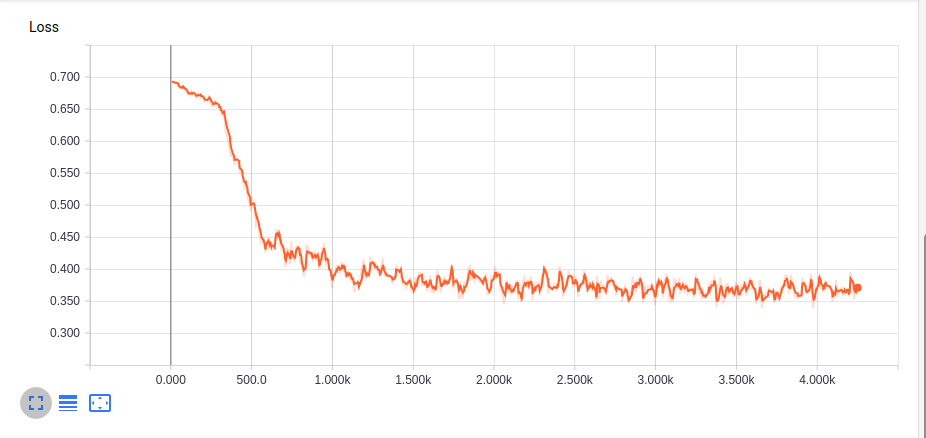

In [1]:
from IPython.display import Image
Image(filename='lossiisc.png')

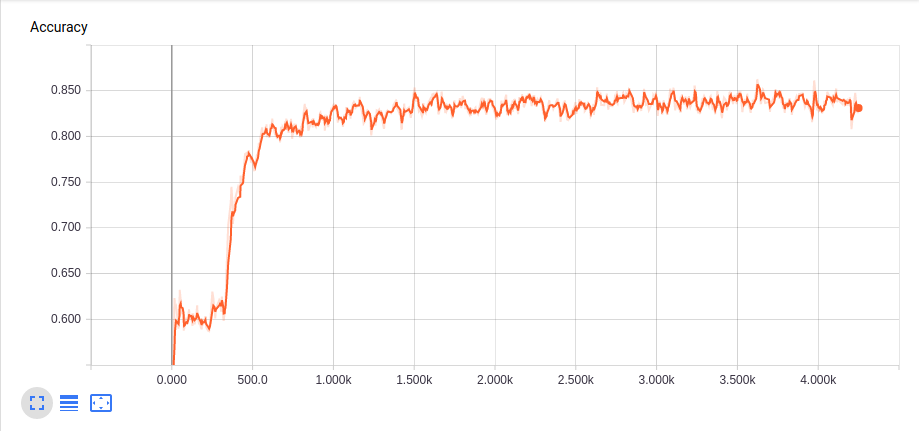

In [2]:
Image(filename='accuracyiisc.png')

In [29]:
model.save('Models/model.tfl')
print(colored('Model Saved!', 'red'))

INFO:tensorflow:/home/bahushruth/Sentiment_analysis/Models/model.tfl is not in all_model_checkpoint_paths. Manually adding it.
Model Saved!


In [30]:
model.load('Models/model.tfl')
print(colored('Model Loaded!', 'red'))

INFO:tensorflow:Restoring parameters from /home/bahushruth/Sentiment_analysis/Models/model.tfl
Model Loaded!


The model file wasnt uploaded due to its size 

In [31]:
import numpy as np
from sklearn import metrics

In [32]:
pred_classes = [np.argmax(i) for i in model.predict(X_test_padded_seqs)]
true_classes = [np.argmax(i) for i in y_test]

print(colored('\nRNN Classifier\'s Accuracy: %0.5f\n' % metrics.accuracy_score(true_classes, pred_classes), 'cyan'))


RNN Classifier's Accuracy: 0.85154



Now let us see the output of our model!!!

In [33]:
ids_of_titles = range(0,1000) 

for i in ids_of_titles:
    pred_class = np.argmax(model.predict([X_test_padded_seqs[i]]))
    true_class = np.argmax(y_test[i])
    
    print(X_test.values[i])
    print('pred_class:', le.inverse_transform(pred_class))
    print('true_class:', le.inverse_transform(true_class))
    print('')

First of all i'm not a big fan of buffet, i tried it because we got a $50 credit for staying here at Monte Carlo in Las Vegas and my friend wanted it so I gave it a chance. Decent taste and There wasn't enough variety of food, service wasn't that great either. so it still doesn't change my mind about buffet.
pred_class: Low_priority
true_class: High_priority

Thanks Yelp. I was looking for the words to describe this place and Meh seems fitting.\n\nPlayboy club is located under Moon at the Palms. We got in for free thanks to the promoter hookup we got. First you can't take glassware from Moon down to Playboy. Security will take your glass and transfer the contents over to a plastic cocktail cup making you feel like you are a four year old when all of the big kids downstairs have real glassware.\n\nThere are a couple of tables here to gamble along with some video poker machines at the bar in the back of the club. The atmosphere here is relaxed and seems to cater to an older (40+) crowd. 

Established in 1958, Los Compadres has been offering Phoenix classic Mexican food at great prices for over 50 years.  Here you will find the Mexican food standards tacos, nachos, enchiladas, tamales, burros etc. made fresh to order.  In addition, they have egg specialties, salads, charbroiled chicken, and their something different selections...  They have 10 combos that include 2-3 items each for under $8 and lighter combos for under $5.  Los Compadres is a excellent alternative to the fast food chains claiming to serve Mexican food.  Catering services and party trays are also available.  Their hours are Monday through Saturday 10:30am to 9pm and Sundays 10:30am to 7:30pm.
pred_class: Low_priority
true_class: High_priority

First, I came here with a coupon from one of those entertainment books my daughter's school sells.  Many items were excluded including the lunch specials and the menudo.  Apparently, to be truly Mexican you have to enjoy eating a cow's stomach in soup -- menudo.  So

pred_class: High_priority
true_class: High_priority

Papa John himself would be disappointed in the level of quality in the pizza's (3) that I received on 08/03/2013. I placed an order online from the 1010 E Desert Inn Rd. location for the special that they had for 3 medium/ 3 topping pizza's thinking that I will do something special for my wife, since she didn't eat anything at work. This was my first time I ever ate Papa John's. Everything was great when ordering and the delivery driver calling to let me know that she is 10 minutes away. When she arrive at our hotel at 7:20PM, I gave her a tip and accepted the pizza's without ever looking at them. As soon as I sat down with my wife in our hotel room, we looked at the pizza's and it looked like the pizza's were cold (cheese getting firm as if it were sitting out long). I called the Papa John's location and spoke with the manager around 7:30PM. He had offered to get new ones sent. I called back at 7:42PM asking the manager if we should

Not the best sushi but the prices are reasonable.
pred_class: Low_priority
true_class: High_priority

Although I have been dining here for years and am sure have written a review, I feel compelled to add another after last night's New Years Eve dinner.   We usually avoid holiday dinners out as the restaurants usually cannot handle the increases numbers.   Not so here!   The food was superb, service more than acceptable and a bargain to boot!
pred_class: High_priority
true_class: Low_priority

Reserved through Orbitz with a debit card and picked up with a credit card because of their debit card policies. Their system was down so they did everything manually, approved it and I was on my way. I returned the car three days later and their computers are STILL down. They receive the car and hand write me a bill saying the card that I gave them would be charged.\n\n The next day I look at my statements and the card I gave them has been charged. I look at my bank statement and they've also cha

pred_class: Low_priority
true_class: Low_priority

Apparently, this place is only hot when a game is on.  I came here on a Saturday night around 10:30pm and there were only 5 other patrons.  The place is huge, so it looked even more pathetic than it sounds.  \n\nI got the Kilt Lifter Scottish Ale, a locally brewed amber beer that was quite flavorful and not too bitter.  They have a good selection of beers on tap including imports and domestic.  I had already eaten dinner, so I didn't attempt to indulge in the Big Unit, but checked out the menu just for yuks.  Quite a variety of options and most meals seem to be named after a certain person.  Cute touch.  But no assignment of credit for who inspired the big unit...\n\nAll the staff here have black teardrops ala Alice Cooper.  Lots of guitars on the walls and three HUGE TV screens above the bar.  Outdoor seating and music blasting in and outside.\n\nThanks to Jim B. for the recommendation to come here.  It gave me conversation fodder :)



First off, the food is not bad here, not great but would give it B+.\n\nThe problem is the noise level; it is horrific.  We sat in banquets by the kitchen and heard every order 3 times and every pan bang.  As if this is not enough noise, they play cheesy music soooo loud.
pred_class: High_priority
true_class: High_priority

Terrible. Just Terrible. \n\nAwful service. Comically horrible band. Way too many TVs. Music too loud and dumb. \n\nSolid beer selection though
pred_class: High_priority
true_class: High_priority

This place is the rip off of all rip offs. My boyfriend and I decided to go there for lunch over the summer. We ordered drinks from the bar, ridiculously priced for a restaurant during the day, $9.50 for some mojitos? Come on. They weren't that good. \nNow we were starving when we arrived, I ordered the tilapia and asparagus and he order the meatloaf and potatoes. \nWe received our food and he dug in right away. I just sat and looked at mine. \n\n\"Fourteen dollars for th

It's the ghetto version of pei Wei.  It's really cheap but nothing to be excited .\nI had higher expectation because the owner  also ones Saigon in chandler.  \nI wish the food is more authentic like Saigon.
pred_class: High_priority
true_class: High_priority

I am disappointed with this company especially after all of the great reviews on here. I called them on Monday, February 18th and left a voicemail to have them call me back for an estimate on a landscape job I needed done. After not getting a return call, I called them again on Thursday, February 21st and left a more detailed voicemail with location and a short detail of the job. As of today I still have not heard back from them. I have called two other landscapers and they have both been out and gave an estimate within a day or two or have at least called to make an appointment. I wish them well in their business but not calling back a potential customer will definitely hurt your business.
pred_class: High_priority
true_class: H

The food here is really good. I've eaten here countless times,sampled many various items and it never disappoints. The staff was always cool as well.\n\n No need to spend top dollar elsewhere.The food is fresh,seasoned well,prepared properly and the portions were generous.\n\nBest of all,its open 24/7.
pred_class: Low_priority
true_class: Low_priority

Great service and the food is the same as I have experienced in Central America --light, not so spicy, and varied in texture. We had a very helpful man suggest items from the menu. I strongly recommend the fruit drink with chunks of fruit (in the picture). And they have pupusas that are really good with fresh coleslaw. Try this as an appetizer. The tortillas are not what you might be used to --they are about 5\" in diameter and thick like a pancake. But they are made fresh and are really nice. My companion had the aroz valenciana which was tasty and I had the Elianas favorite which was grilled chicken with that terrific latin american cr

Always remember. You get what you paid for. Don't expect high quality Japanese food.  I decided to give 3 stars because food is about average. I ordered lunch combo D and spicy tuna roll.  It comes with Chicken, vegetables, edamame, potstickers and a drink. \n\nChicken was  dry, it was expected.  I think many people have commented same about chicken being little dry.  It is cooked on charbroiler. So expect the little dryness.  \n\nSpicy tuna roll was fresh and enjoyable. I think they just made it when i ordered it. So make sure to ask when it was made before ordering.  Because it is already made and stored inside the container.\n\nService was good. Owner was friendly and attentive. \n\nFor the money. This place is a great for quick lunch. I would revisit again if I am in the area.  However, I wouldn't make an effort to drive the distance just to eat.
pred_class: High_priority
true_class: High_priority

Our favorite local grocery store. Always clean and will have whatever you need. The 

Normally my family is particular about sticking to the tried and true Chinese restaurants. It is rare to get my mom and dad to deviate from their regular rotation. When my dad suggested this place, it took me by surprise. The Yelper in me is always in search of a hidden gem.\n\nHK Garden is not that kind of place. It is jammed pack with tables of screaming, uncontrollable children. The Asian teacher in me wanted to expel some corporal punishment, but decided against it. A few stern looks were enough to get them into the seat next to their mother. \n\nThe service is lacking. Of course, it is lacking, it is a Chinese restaurant. Of course, I am going to get ignored when I need them most. \n\nThe food is a hit or a miss. \n\nThe seafood and tofu hot pot: hit. \nThe mapo tofu: miss.\nThe porks blood and intestine hot pot: hit.\nThe HK sweet and sour spare ribs: miss.\nThe whole fried flounder: hit.\n\nApparently if $40+ is spent, you get a free entree. We got the flounder. There is somethi

A casual place to eat and drink in Tempe.  Lots of outdoor seating and is a great place to come with a group of peeps to eat, drink and be merry.
pred_class: Low_priority
true_class: Low_priority

Once upon a time, I actually stopped for a moment to hear out a Mill Ave promoter...\n\n\"Come in! It's only five dollars\" shouts the peddler. I let out a hearty laugh. A cover on a Sunday night? Not I. After taking a glance at the hotties I had traveled with, the doormen obliged, and we were whisked to the second floor, feeling thirsty and excited.\n\nWe reached the summit of the staircase, with jaws held agape. This place was a ghost town. Should we leave and try to salvage our Sunday elsewhere? No, that's too risky, other bars could already be closed. So we stand in the empty lobby for a good 20 minutes, before the ladies settle for some bottle service at a table. You DO know, that's the only way to get a seat here, right? \n\nTotally. fucking. worth it. $40 lands a bottle of Strawberry A

Solid! Good sized portions, decent quality meat. Better than Samurai Sam's.
pred_class: High_priority
true_class: Low_priority

Probably the best on campus. They spray A LOT for bugs, which is awesome. They take care of almost everything right away. It's a family owned business and they do a great job. \n\nThe only thing that was  odd  was their payment plan. It was a bit confusing but just make sure to ask lots of questions.
pred_class: Low_priority
true_class: Low_priority

Came here last night to study w/ a friend and THIS PLACE IS SO CUTE :D I love the ambiance here. Free wi-fi is always good although a bit slow. I really wish southeast had cute little places like this! \n\nI ordered their green tea since it is refillable and green tea anything is always good. I really love the setup of their decor and hot teas w/ a small fire underneath the pot. Pot is very heavy though, needed my friend to help hehe\n\nI wasn't even planning on eating their honey toast, but there were other group

Hubby and I tried this place for the first time a couple weeks ago. I was in search of Bubble Tea and discovered they had it. The food was amazing and the Thai Tea (with boba...hubby got a smoothie with boba) was what put this place up and over the top for us. We went back again this afternoon for lunch and was pleasantly surprised with 2 free egg rolls. We have found our new favorite Chinese restaurant!!!
pred_class: Low_priority
true_class: Low_priority

Now the Medley Buffet, We came here on a Friday for lunch for $9. We used 10k points for $10 of dine-in credit. \n\n- Like a Feast buffet but a different Chef. They took the chef from Red Rock. \n- They have a buy 1 for 2 promo Mon-Thurs only.\n- Ribs are tough.\n- I come for the Mexican food! Yum! \n- Make yourself taco fries and meatball tacos with sour cream! \n- No sushi for lunch\n- Single price is $9 with players card but at a station casino, it's $8. \n- Fried chicken is worth getting\n- Leave with an ice cream cone!\n- Good v

Yelp is just such a help when searching for places to eat. Having come across this on yelp we decided to give it a try. The parking lot is waaaay tooooo small for the amount of people who dine here, but somehow we managed to secure a parking spot. \nOnce inside we found out that there was a wait, but she mentioned that there was availability at the bar. We immediately decided to sit at the bar and we were waited on right away.\nAll of the burgers looked great and we both had no complaints over our food whatsoever. Very tasty and loved the fries as well. \nI would go again in a heartbeat, and certainly hope they make their way to Raleigh some time soon.
pred_class: Low_priority
true_class: Low_priority

Really impressed with the service and selection. They have a system where you turn an egg on the top of the table to notify the staff if you need help!
pred_class: High_priority
true_class: Low_priority

I've always held a special place in my heart for Cheba Hut. It was definitely a coll

Me & some friends came here for lunch but an hour pass by & we never received our food... we end up leaving because our lunch time was over... never coming back to this restaurant
pred_class: High_priority
true_class: High_priority

AVOID this place at all costs.  I've never been treated so disrespectful in my entire life. \n\nCame here last night with 3 friends after having dinner at Squid Ink since it's the only bar in the area.  Ordered a beer for myself and 2 of my friends and was promptly told that in order to get the drinks I would need to surrender my keys.  Ok... I told them and I gave them my keys even though I didn't even bring my car here.  My friends and I ordered shots, then went on the dance floor and goofed around having a good time.  When I went to order another drink I was told by the waitress that I was \"too drunk.\"  \"Excuse me?\" I asked her, \"I've had 2 drinks!\"  When I asked for my keys back she just flatly told me, \"No.\" I went to find a manager and a burly

A lot of people I know consider Vegas a true desert when it comes to finding outstanding food. Food that blows you away and makes you want to come back to Vegas just for a particular restaurant. They say it's glitz and glamour, expensive and flashy, and food takes a backseat. No where else is this more true than STK. \n\nIt's a great looking restaurant. It's hip with loud music and good looking servers and bartenders. You're definitely not at a loss for eye candy with the patrons. Actually not a bad place for the fellas to have a group dinner if they want to drop some coin on a place where food isn't the emphasis. Unfortunately I was here dining alone on business and food was my only friend.\n\nI don't think I need to go in to detail because I've personally never cared for detailed reviews of mediocre food.  I will say this.... at some level a place like this does have to get certain things right.. I mean, people do have taste buds and people do come here. So as long as food isn't the 

There's a pretty large parking lot at this location so you'll always fine a place to park. However, this place is always packed and understaffed. The line is always backed up because service is so slow! Be prepared to wait a while during lunch and dinner hours. This Chipotle location is also pretty stingy about their portions too. Ask for extra of everything when you can!\n\nTIP: If you don't want to waste your time waiting you can order online and skip the line. Just go to the cashier to pickup your order. \n\nI would recommend going to the Chipotle on Baum. The service is MUCH faster.
pred_class: Low_priority
true_class: High_priority

I came here specifically  for underwear night.   LAME!!!  Only me and my bf were in our underwear.  And there were only 5 other people here.  Never again!
pred_class: Low_priority
true_class: High_priority

This place is a lot of fun. We have a large distributor out of Turkey, so we've made many trips to this place and made friends with Yusef, the owne

Loved living here....for the past 6 years...always quiet and safe. Until there was a shooting last night that they arent doing anything about...I wouldnt move here because the safety of the tenants is not a priority
pred_class: High_priority
true_class: High_priority

Great for a quick Blizzard fix. My son loves the burgers I haven't tried the food besides the blizzard
pred_class: Low_priority
true_class: High_priority

I'm not sure how you can call your place an English pub when you don't serve English beers. Bud light isn't an English beer. On top of it all the food was just ok. My advice pick another place to eat.
pred_class: High_priority
true_class: High_priority

1st lunch in Vegas on 9/11/14.  Party of 4.  Sat outside and did have a view of Bellagio fountains.  Found the menu a little limited.  Loved the crepe
pred_class: Low_priority
true_class: High_priority

Service is superfast, however the servers look like they don't wanna be there :) \nnow to the quality of the pho, I've 

WOW!!!  First off, the place is gorgeous.  Hats off to the designers and craftsmen that put this place together - well done - very well done.  I attended the friends and family opening the other night; a good friend of mine Tay Black invited me..  Tay gave me a tour and I was really impressed.  I was especially impressed with the coffee shop.  Tay told me they will have coffee on tap; that is not something you can really find in Scottsdale so I'm super excited about that..  On another note I wanted to point out how professional and courteous the security staff was. Their security is obviously not your run of the mill old town \"bouncer\"..  \nBetween the awesome staff and good food and great atmosphere I'm sure Dakota is going to be the new go to spot for Scottsdale's young partying professionals.
pred_class: Low_priority
true_class: Low_priority

Sadly really wanted to enjoy this place with the ideas of fresh non GMO foods etc that they have but they have a small variety only one Vega

I did not get a sandwich from here. I ordered the spicy ramen noodles since it was a chilly, rainy day. I was genuinely shocked on how amazing it was! Not that I didn't think it would be good, but it was seriously some of the best stuff I've ever had. I now crave it at least once a week! \n\nNot only did the amazing soup earn them the 5 stars. The service was awesome. I only ate about half a bowl of soup and asked for a to-go container. The lady came out and separated my noodles from the broth and put them in different containers. She also explained to me how to reheat it properly so it doesn't ruin the flavor. She then taped them tightly shut so it didn't leak in my car.\n\nFYI this is an \"order at the counter\" type of place. This type of superb service was totally unexpected, but greatly appreciated. I was able to eat the rest of my ramen the next day and it tasted just as fresh and flavorful as when it was first served. This was all thanks to the wonderful service of this sandwich

feel like it was overrated.\nthe full montagu tasted like a panini that was bland.\nand the cold pasta in a cup was too sweet.\nthe potato salad in a cup was not bad though.\nthe frozen lemonade was way too sweet.\nnot impressed.\n\nand the cobb wrap was not good.
pred_class: High_priority
true_class: High_priority

After my poor, 4m old Alaskan Klee Kai got attacked by a mean and aggressive chihuahua back in 2009, she was not the same, sweet and well-tempered doggie. She would display aggression toward unfamiliar dogs that came near her and myself and would guard my fiance and me. I was in desperate need for help and asked some fellow dog owners on places to have her trained.\n\nWe scheduled a consultation with one of their trainers at the facility and he said he was concerned that my dog was displaying a bit of dog jealously when she saw me giving attention to another dog. He also explained that their e-collar was NOT a shock collar but was a training device to grab the dog's attenti

Wow I watched a bar tender call security for a guy that was black out drunk with a friend. He also called to get hookers off his bar talking to the guy blacking out at the bar. I watched the security guards walk by looking at the hookers obviously doing there thing and walk away. So if your drunk and probably want to be taken advantage of by hookers you found it.
pred_class: High_priority
true_class: High_priority

When I go for wings, I prefer to pretend they're not actually from a chicken. While I'm not a fry-gal, please grill, bake or fry my wings so I am not reminded that it once had skin on it. Well I took my work team here before a Checkers' game since we had some picky kids with us who apparently love Hooters (and I refused to take a work group to Hooters) so I thought this was a good choice. Uck. The wings were so soft that you can see where each feather is plucked out. Blech. The sauces tasted good, but the wings seemed really under done and the meat in the middle was oddly ch

Ambience like Cheesecake Factory, for sure, and I love Cheesecake Factory, the way it makes you feel all warm and cozy. The dim lighting sets the mood. I got the Pasta Pomodoro, which was pretty good, just tomato sauce, basil, and angel hair. I only wish the pasta was more al dente. The pasta with clams was full of clams. Great, prompt service.
pred_class: Low_priority
true_class: High_priority

suncoast is sooo empty lately.  No one really seems to be coming here any more.  Their food/restaurant options are blah and boring, most of their restaurants don't even open during the daytime anymore (only for dinner)  Service throughout the place is fair at best.  As far as the cafe, their menu is very simple and boring and a little over priced.  However their lunch special for their asian food is surprisingly good, and good portions too (only $6.99)  You get a choice of egg drop soup or hot and sour (i've had both before and both are quite good)  an egg roll and I ordered the general chicken

Service is terribly slow. Orders have never been correct. Manager Oscar is trained in a third world country. I have boycotted this location for the last year and I live and work within walking distance of this place. I'd much rather go out of my way and give my money to the Boca Park location.
pred_class: High_priority
true_class: High_priority

attended for the special nuit blanche 2012 menu. the food was good. nothing too memorable and no real stand outs. service was good enough.\n\nyou won't go wrong here. be prepared to pay a price though, the decor comes at a cost.
pred_class: High_priority
true_class: High_priority

Have had dinner here twice. The first time had the Dungeness crab and shrimp boils.  Delicious shrimp, tasty and succulent. The crab was not as wonderful. Having been from San Francisco, we have eaten A LOT of  Dungeness crab. This was a little mushy (well more than a little). \nThe second time here, we skipped the crab and had the shrimp boil and added the clam boil,

Niece's husband is a Glendale firefighter of mixed ancestry including Asian, Puerto Rican, and Mexican.  Took their three kids in for lunch.  Sat down, every eye in the place was on them. I kid you not- and I'm as caucasian as they come.  Five minutes pass, no acknowledgment from waitress.  Two couples walk in a  few minutes apart.  Waitress goes to those tables, brings menus, drinks.  After fifteen minutes my nephew and the kids walked out.  Absolutely horrible. How arrogant.  I don't think it was a coincidence.  I do think that the management is stupid, since they may someday need the services of civil servants who are not the same race as they are- will they ignore them as well?
pred_class: High_priority
true_class: High_priority

We drive 11 miles each way to get the best Chinese food in the East Valley. The restaurant is small, clean, and the owners are polite and very helpful. The food is always fresh and The portions are large. We've always picked up our food and take it home be

I go often because the staff is very friendly and knowledgeable.  I was more educated on what i wanted to smoke and the employee Robert knew exactly what i was looking for to enjoy the experience of a fine beautiful cigar.  I live quit away from the place but i continue to go to Tobacco Leaf because the ones closer to home (at least five others) are very ghetto, they watch TV more than help you, and prices are higher.  The Tobacco Leaf has a fantastic cigar lounge and a large humidor with great selection.  Thank You Tobacco Leaf!
pred_class: Low_priority
true_class: Low_priority

If you're looking for Mexican food, you need to come here.  The food and drinks were fantastic.  I must admit that I take pride in knowing good, authentic Mexican food, and especially margaritas.  I'm so happy we tried a sampling of several items, the appetizers, a few entrees, and even the desserts.  Everything was exeptional.  Tip:  I don't typically expect the desserts at a Mexican restaurant to be anything

I saw this place featured on DDD and my mouth watered upon viewing the apple cake and dutch baby. I drove the 45 minutes up the 101 to get my hands on this delectible meal. The service was ok, nothing special, borderline rude, but I don't let that ruin my meal if it's good. I was super happy to see that they offer Junior portions of their famous pancakes. So yes, I had two. I ordered the apple cake and the dutch baby (don't judge me) Both cakes were better looking than tasting. The middle of both cakes were a unsweetened chewy flan-like consistency. The edge of the apple cake was ok so I ate that along with my hashbrowns and bacon but still left slightly unsatisfied. I also had to pay for the rest of my party when we realized that they do not accept credit cards! ????!!!! There is an atm that charges a $5 fee, yay. I won't be back, the drive is too far for something that is just meh.
pred_class: High_priority
true_class: High_priority

The fish nibbling deserves five stars.  It's autom

true_class: Low_priority

I've been to cluck-n-cup southend three times now and every time was a bad experience. The first time I went in they were out of chicken! Not sure how a chicken restaurant can run out of chicken in the middle of lunch time. The second time I went in they were out of turkey! Today was strike three, and I will not be a patron in the future. When I went in for lunch today, I asked for a menu and they were out. Out of menus. I asked the cashier what my options were and he was just as helpful as the menus they didn't have. I asked if they had an online menu and he said he thought so. I pulled up their website on my phone, clicked on the menu and it lead to a dead page. I left and went across the street to noodles and company, where I received fantastic service, they had menus, and chicken! I will say that the food I was able to get the last couple of times was good, which is the only reason I'm giving them one star
pred_class: High_priority
true_class: High_priorit

I have been coming here for about 10 years. My aunt had found it on one of her visits to us and said we would try it. Thank goodness we are breakfast ppl! There are 39 omelettes alone! Not to mention regular breakfast offerings such as fluffy waffles with a hint of almond flavor. They also offer lunch, burgers, sandwiches and soup. The Fried Zucchini is amazing, light batter around thick cut spears of squash. I ordered the Lobster Fest omelette, baby sized for .89 cents less, its 3/4 the size of the reg omelette avail on any omelette, this was stuffed with chunks of sweet luscious lobster and slices of buttery avocado. Accompanied by homestyle spuds and choice of warm pumpkin nut bread, toast, or when available, banana bread. I always say I'm going to try lunch, but inevitably end up with a scrumptious omelette.
pred_class: Low_priority
true_class: Low_priority

If your room at the Flamingo is near the right elevator, this place deserves two stars because it's convenient.  If your room

Food wasn't bad. But the waitress was a disaster. We ordered appetizers and the dinner special which included soup and salad. The appetizer arrived and a minute so did our entree. We asked about our soup and salad and the waitress said she would bring it right out. When we reminded her that the soup and salad should come after the entree she was at a complete loss about what to do. So we told her to forget about the soup and salad and take it off our bill. They reduced the bill for $3.48! The poor kid had no training and failed to follow up or apologize for the screw up. Other than that the good here is decent. Just make sure you get a seasoned wait person!
pred_class: High_priority
true_class: High_priority

Food presentation is good but the Ma-Po Tofu leans too heavily on salt. The Garlic Noodles were more subtle. The Spring Rolls were crisp and fresh from the fryer  Lunch prices seem reasonable. Portions  are reasonably sized rather than super-sized with lesser ingredients  Good pla

Go figure that this place would close. I've been to the original one and that one was a million times better than the one here in Dallas. The fries were mushy and gross, the burger didn't taste half as good, and the entire place was simply dirty looking. I couldn't even finish my burger and fries when I was there. I kept thinking over and over on how much the original one was so much fun from the moment I entered, to walking up the fry station, to leaving stuffed.\n\nOh well... I guess everything is worth the try.
pred_class: High_priority
true_class: High_priority

The people here are ridiculously nice. I came in here at night after dinner once with a group of friends and among the 6 of us probably tried 20+ samples. (We all got many many scoops of gelato to make up for it though!) \n\nIt isn't Italy but it is still delicious. You can never go wrong with the coffee flavor and I swear one of their flavors tasted exactly like Ferrero Rocher. Their fruity flavors were wonderful as well. 

Just bad. It is now 2:30, my appointment was at 12:15. To have people waiting this long is just rude and bad business. The only reason I come here is because I already paid for the eyecare club. After this one is up, I will be taking my business elsewhere.
pred_class: High_priority
true_class: High_priority

I would do anything for the ribs at this place.  Falling-off-the-bone flavorful and tender goodness.  \n\nBest ribs I've EVER tasted.
pred_class: Low_priority
true_class: High_priority

We go to this IHOP on occassion an it has always been fairly good.\nWe had an Anniversary Coupon, and Lupe was our server. She was nice and friendly.\nFood was good.\n\nPS, not very happy they don't seem to have the NY cheesecake pancakes anymore. Hubby was unhappy, Daughter was devastated...
pred_class: Low_priority
true_class: Low_priority

Food was decent but the service was horrible. I had to ask for my drink multiple times before it even showed up. Seemed like they only had 1 server working the

Solid restaurant. A gringo wonderland. I have lost my license and needed a dinner spot close enough to my hotel that I wouldn't run the risk of getting pulled over (i'm a hysterical driver...watch out Phoenix) and Ajo Al's reviews were pretty decent so I headed down to get some fish tacos. \n\nI was scared about anything saying \"Del Mar\" after my Frank & Lupe's experience but though the Hawaiian Ono in the Tacos del mar ($11.95) was previously frozen, it was an enjoyable experience. I've never had Ono and to me the texture was like that of swordfish, which is just fine for a tiny soft taco. It was a little chewy, but again that's because it's frozen. The beans and rice were okay, and there was some sauce for the tacos that was okay too...not exciting enough for me to remember what the sauce was though, or what it tasted like. \n\nWhen seated you will be presented with the world's largest basket of ultra thin tortilla chips you've ever seen, whether you are one person or 6. They were 

My wife and her family went there for lunch.  Found a bug crawling out of  one of their salads!  Never going back to this place and telling everyone I know to avoid it.
pred_class: High_priority
true_class: High_priority

This place used to be good, but that was years ago.\n\nToday it's very dirty with food that just doesn't cut it.\n\nThe salsa is still good so that gave it a star.
pred_class: High_priority
true_class: High_priority

This is one of my favorite places to eat in the valley! Delicious food, comfortable atmosphere and late hours (serve food until midnight except for Sundays) is the reason my girlfriend and I frequent Cornish Pasty Co. The different kinds of pasties they offer are VERY diverse (anything from exotic flavors like the \"red curry chicken\" and \"lamb and mint\" to traditional flavors like \"italian\" and \"reuben\"). Of the 38+ flavors they offer, I have probably tried about 10 of them and haven't found one I didn't LOVE! I live 40 miles away form this locati

Sooo fresh and yummy. A little on the expensive side for the price of one donut ($1). I'm used to them being 50 cents each at certain places but its the closest to me so I put up with it.
pred_class: Low_priority
true_class: Low_priority

The worst Hilton we have ever stayed at. Do not stay here thinking that there breakfast is like any other Hilton's. We went to breakfast at 9:15 on a Sunday morning and they were out of food plates and silverware. And never brought out anything. They tables were all dirty. They didn't wipe any down. The staff was rude. When i and other guests asked at 9:30 if they were going to bring out more food they said they said no because they get done at 10:00. I had toast and coffee.
pred_class: High_priority
true_class: High_priority

My experience is probably not normal, but should be stated.  I walked in and then a masked man walked in behind me a held me hostage.  When he said I'll shoot if you don't open the regester, this fat redneck chick said go ahead 

Just had Taylor come by for rockstar party for my 6-year-old. They absolutely loved her. Second time using Celebrate Kids. Would definitely use them again.
pred_class: Low_priority
true_class: Low_priority

Let me first preface this review by saying A-this was our first visit to Las Vegas and #2 we are not picky people at all, so that being said, I need to first apologize to the all the yelpers that posted a negative review of this place...I wrote you off as being super  picky complainers...for that I am sorry...I went, I saw..now I believe...everyone that posted a negative review was 100% right!!!\n\nSo on to my experinces...\n\n1) Check in was a nightmare, there was a super long line, a couple of flustered peope behind the check out desk...but as I waited I drank...then drank some more...thank GOD for booze and I was feeling no pain after the almost 1.5 hours it took to get through the line and check in.\n\n2) Got to our room, seemed nice enough although not too clean...oh well..I'm 

I must not have great luck with Holiday Inns, especially in Pennsylvania. This hotel is decent enough in terms of looks and rooms, and pricing. However, one really annoying thing about it is their vending machine situation. They are not very well-stocked, and I was sent to multiple floors by their lobby staff, all in the search of a bottle of water
pred_class: High_priority
true_class: High_priority

Great outdoor patio.... Food and service was fantastic... Decent lunch prices... The open face sandwich and fries was incredible.
pred_class: Low_priority
true_class: Low_priority

Decent selection of designer stuff though some of it still seems overpriced, you need to have some time to go through some of the clothing racks.  Parking access is alright but sometimes limited since it is in the corner of the shopping plaza.  They offer paperless receipts which I love, eliminates some of the millions that float around in my purse.  Also if you need to return stuff they can look it up w the cre

Eaten high-end sushi in San Fran, NYC, Vegas..the Sanchez roll at Sushi Brokers in Scottsdale is the best roll I have EVER had... Great atmosphere, great wait staff... Highly recommend!
pred_class: Low_priority
true_class: Low_priority

Their food is delicious. I order take out as well as dinning in from time to time. I always order scallop hibachi which comes with soup, rice, sweet carrots, salad, and of course scallop. On this occasion the sweet carrots were missing once I get home, so I called just to let management know. The manager was unsympathetic and said sweet carrots are not guarantee and come with hibachi to \"make look pretty.\" Unbelievable! The food is excellent just make sure everything is in your to go orders. And if your missing anything don't call....nobody will care.
pred_class: Low_priority
true_class: High_priority

Food is always fresh & hot. The wait staff is very attentive and friendly. Can't really say anything bad about this Golden Corral. It sure beats the on

I can't tell you how the food was because we went almost 10 mins ( or the duration of 2 songs) without someone checking if we even wanted something to drink.  The people next to us looked like they didn't have anything on their table either and they were there before us.
pred_class: High_priority
true_class: High_priority

Oh Dads. Quick breakfast/lunch, great to have nearby to grab some quick or ready to eat food on the go. I know them as being open 24/7 but apparently that has changed recently. It was always the same gentleman behind the counter, smiling and grinning at the drunks that walked through his door. I remember one night he asked my friend and I if we had been drinking (we most certainly had) and whipped out a bottle of Jameson from beneath the counter and said \"ME TOO!\". We ended up leaving with a dozen bagels, 10 beef patties, a big bag of wings, and half a bag full of things we didn't even order. We left having paid only $12 and he gave us each a styrofoam cup with 2-3

I love my Salvation Armys... sorting clothes by color and size, what a novel concept! This one used to be stellar but lately they don't have nearly as many clothes (at least not guys' clothes, anyway), so I don't go here as often. But the prices are fantastic. I can't tell you the joy of buying a rocking tshirt for 99 cents, only to have it be the \"color of the day\" and end up getting it for 49 cents!
pred_class: High_priority
true_class: High_priority

Their chocolate is quite tasty, but their truffles were not for me. For example, the chai truffle has a very strong kick of ginger, but I prefer chais that are smoother. I also like a thicker coating of chocolate on my treats. Don't let my personal preference stop you from trying some, though. I tend to be picky. \n\nThe shop is family owned and operated and everything is made fresh. We've been in a few times since they opened and the family has always been very pleasant to chat with. If you're looking for a savory bite or something a

I don't know where to start. From the time I walked in I was speechless. This resort is gorgeous! The staff was very friendly and they truly made us feel like VIP. We live here in town and staying here for a staycation was so relaxing and peaceful without the chaotic loud mess the strip resorts can bring. The Westin has just gained two big fans!!
pred_class: Low_priority
true_class: Low_priority

So an American walks into an Irish Pub in a French-Canadian city... talk about your cultural cocktails. Despite 90% of the customers speaking French, you could mistake Grumpy's for a classic pub in New York, or Dublin for that matter.\n\nUnderground, dark, chill... one TV off to the side just in case you want to watch something on TV... that's the way an Irish pub should be; heck, even the TV is optional.\n\nBartender was great. Really nice, attentive, and quick.
pred_class: High_priority
true_class: Low_priority

Liquor World is in kind of a sketch spot.  I found this place while staying at t

I understand why people would want to like Mary Coyle. They serve ice cream in every way imaginable. The nostalgia. They hand make/pack the ice cream. They have a drive through. \n\nNow here is why you would not want to like Mary Coyle. It is overpriced. Your cholesterol will raise by at least fifteen points before you leave. Dimwit 16-year-olds work there. The bathrooms are gross. I have had better soft serve cones at McDonald's. \n\nHere is the deal: everyone should try out MC once just to say they have been there, but beware, make sure you wear your fat pants and make sure you know where the nearest hospital is just in case someone in your party gets a clogged artery.
pred_class: High_priority
true_class: High_priority

Visited for Restaurant Week so we had a shared app (crab cake), two entrees (Carolina burger w/string fries and fish and \"chips\"/string fries) and shared dessert. The waiter was friendly but somewhat unattentive and tried to push the other restaurants/deli on to us

***LONG OVER DUE REVIEW INCOMING IN 3...2...1...\n\nStanding in line for check in with my buddies, I noticed some really noticeable and some not so noticeable things.  The most noticeable was the heavy smoke inside the casino.  Occasional faded stains on the carpets in the casino were also very noticeable.  Somewhat not so noticeable was the feeling that you weren't in Vegas.  Another not so noticeable fact is the crowded nature of the counter to the beginning of the casino.  The latter may not seem like of much importance.  In perspective of dialogue that will be presented, significance may arise.  Now after using the word \"noticeable\", a noticeable amount of times, I'll continue.   \n\n-Hotel Clerk:  Hi, how can I help you?\n\n-Arnold (me obviously): Uh...we'd like to check into our rooms.  \n\n*HOTEL CLERK CLICKS AWAY AT THE COMPUTER AND SCANS THE ROOM KEYS.   \n\nHotel Clerk:  Alright, here are your room keys.  Have you stayed with us before?\n-Arnold:  This will be my first.\n\n

This place has an awesome deal on Thursday nights(not sure if it's all day)!  This is the only time we really go to the movies because the price is better than paying for a student ticket priced at $7.  So for a better theater than harkins or AMC thats a great deal!  I like how far the chairs can recline back but i don't think the regular seats are anything worth bragging over or highly recommending because they feel kind of cheap like a fake leather and definitely not LA-Z boy status.  just a nice theater seat spruced up and not as cushiony.  service cannot really tell you because i have not gotten much interaction with anyone. My boyfriend hands me my ticket we hand it to the ticket stub person and off we go. No customer service to review/critique.\nFrom what i can remember the better chairs were okay not on Ipic level but better. is it worth the extra money on a Thursday if you could upgrade id say yes. but on a regular day no.
pred_class: High_priority
true_class: High_priority

Gy

I was in town for  2 days of course had to check out the local Bikram Yoga studio.  It was the closest off the strip after all. (part of their marketing..)  Technically, it was about a 15 minute drive. Glad I rented a car and didn't take a cab. \n\nThe owner checked me in and  was familiar with the owner here, by name. I was impressed. He did ask me if I took a cab so, if needed they could have a cab ready for me after class. Also impressive!  The studio was whistle clean. I'm not sure what these other folks were yelping about.  A lot of Hot Yoga studios do smell like dirty feet. This place did not!  Yes, the room did have carpet but whatever the fiber was, didn't hold onto sweat or stink. Yes, the room was hot. It's known as hot yoga for a reason. Anyone who attends Bikram knows they can lay down on the mat at anytime (Savasana). \n\nMy first day of class had about 40 people and second about 30. I had Marie one day and Amy the next.  Marie was over the top happy. It must have been tha

I purchased a groupon for a partial, deep conditioning, cut and style. I really liked the atmosphere, but the reason I'm giving a rating of 2 is because my stylist Chealsie. She didn't listen to my request at all! I told her how I wanted my color and I even showed her a picture. She told me she does the bangs a certain way and I told her I didnt want them that way She ended up doing what she wanted. My roots were showing as if my hair was done at least a month ago. I also have the horrible tire marks on the side when I put my hair up!.She also complained the whole time about how tired she was cause she was out late with friends! Anyways I would have gone back and complained but I went into labor. So being a first time mom I'm now stuck with this awful hair style. All I wanted was a simple color and cut to last me for the next few months while I enter the world of motherhood. I guess I'm better off wearing a hat. Thanks Chealsie! As for the salon itself, everyone else was courteous and 

What were we able to achieve from this?

We were able to sucessfully distinguish high priority statements from low priority statements.
1. With the help of this model we are able to sucessfully rank comments/reviews based on priority.

2. We are now able to easily analyse what the consumer has to say and extract valuable insights. 

3. With the help of this model we can monitor social media and and understand the needs of consumers.

4. Able to identify spam from an actual review. 

Further improvements 

1. The accuracy of our network can be improved by using bidirectional LSTM instead of unidirectional LSTM
   Training a bidirectional lstm can be computationally expensive.

2. Better preprocessing of the dataset could improve the accuracy

3. A model that was trained to identify more than just 2 classes
   Like Spam,Low_priority,Medium_priority,High_priority
   This could be achieved using the existing dataset

4. An additional layer in the network that could identify keywords in the review and propose sentiments to further    help in analysing consumer reviews 